In [20]:
import numpy as np
import math
import pickle
import cv2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
from scipy.stats import norm
%matplotlib inline

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

In [26]:
path = '/home/octo/Desktop/simulator-linux'
column_names = ['center', 'left', 'right',
                'steering', 'throttle', 'brake', 'speed']
data_df = pd.read_csv(path+'/driving_log.csv',names=column_names)

In [27]:
data_df.iloc[15:18]
#data_df.head()

,center,left,right,steering,throttle,brake,speed
15,/home/octo/Desktop/simulator-linux/IMG/center_...,/home/octo/Desktop/simulator-linux/IMG/left_2...,/home/octo/Desktop/simulator-linux/IMG/right_...,0.0,0.0,0.0,0.000080
16,/home/octo/Desktop/simulator-linux/IMG/center_...,/home/octo/Desktop/simulator-linux/IMG/left_2...,/home/octo/Desktop/simulator-linux/IMG/right_...,0.0,0.0,0.0,0.000079
17,/home/octo/Desktop/simulator-linux/IMG/center_...,/home/octo/Desktop/simulator-linux/IMG/left_2...,/home/octo/Desktop/simulator-linux/IMG/right_...,0.0,0.0,0.0,0.000078


In [28]:
data_df['center'].iloc[15:20]

15    /home/octo/Desktop/simulator-linux/IMG/center_...
16    /home/octo/Desktop/simulator-linux/IMG/center_...
17    /home/octo/Desktop/simulator-linux/IMG/center_...
18    /home/octo/Desktop/simulator-linux/IMG/center_...
19    /home/octo/Desktop/simulator-linux/IMG/center_...
Name: center, dtype: object

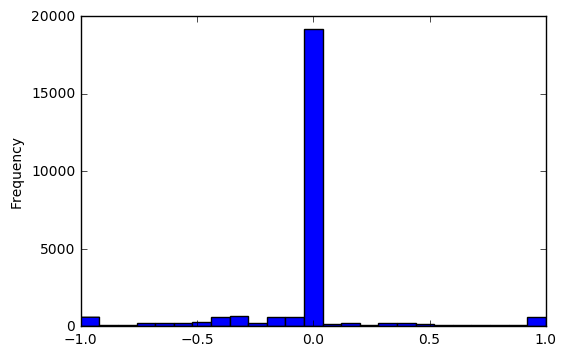

In [29]:
data_df['steering'].plot.hist(bins=25)

In [30]:
data_df['steering'].describe()

count    25653.000000
mean        -0.028761
std          0.290527
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: steering, dtype: float64

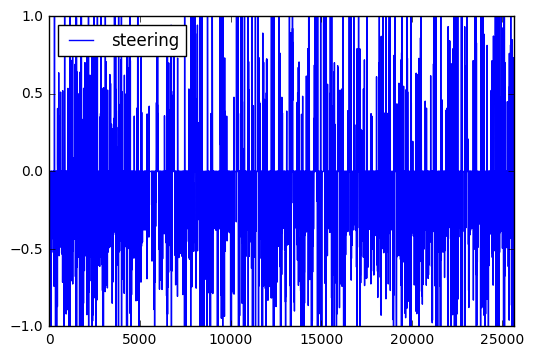

In [31]:
data_df[['steering']].plot()

In [32]:
data_df['brake'].value_counts()

0.000000    23268
1.000000     1842
0.363270        1
0.832899        1
0.448047        1
0.306124        1
0.430845        1
0.486129        1
0.858894        1
0.422796        1
0.859914        1
0.723078        1
0.228208        1
0.839122        1
0.832657        1
0.399280        1
0.618294        1
0.560347        1
0.702141        1
0.638620        1
0.512730        1
0.253081        1
0.086442        1
0.156863        1
0.078269        1
0.661345        1
0.267772        1
0.797274        1
0.552484        1
0.597592        1
            ...  
0.903342        1
0.552237        1
0.323913        1
0.286855        1
0.261751        1
0.839634        1
0.182406        1
0.904176        1
0.907027        1
0.291544        1
0.306451        1
0.092289        1
0.923032        1
0.573301        1
0.722748        1
0.074316        1
0.841164        1
0.095310        1
0.909784        1
0.317041        1
0.093577        1
0.933168        1
0.172641        1
0.175350        1
0.094035  

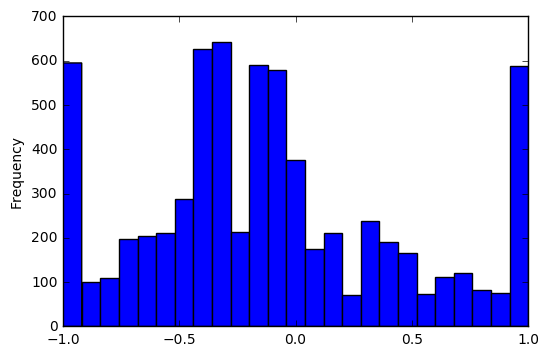

In [33]:
data_df.query('steering != 0')['steering'].plot.hist(bins=25)

In [34]:
# Extract centre image and steering angle from table
# Format: X_path: image name, y: steering angle
center = [data_df.loc[i]["center"] for i in range(len(data_df))]
left = [data_df.loc[i]["left"] for i in range(len(data_df))]
right = [data_df.loc[i]["right"] for i in range(len(data_df))]
steering = [data_df.loc[i]["steering"] for i in range(len(data_df))]

In [35]:
images_center = [mpimg.imread(image_path) for image_path in center]

In [61]:
#images_left = [mpimg.imread(image_path) for image_path in left]

In [63]:
#images_right = [mpimg.imread(image_path) for image_path in right]

Sample Image Center: 25653


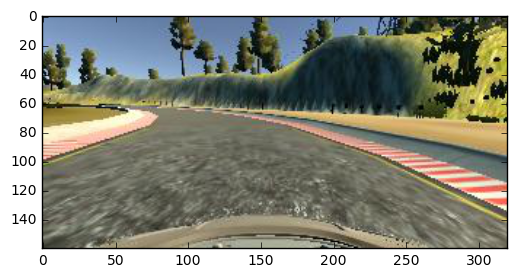

In [37]:
# View image
print("Sample Image Center: %d" % len(images_center))
plt.imshow(images_center[0])

In [22]:
images[10].shape

(160, 320, 3)

In [23]:
img = cv2.imread("/home/octo/IMG")

In [69]:
# Get steering angles for controlled driving
angles = np.array(data_df['steering'])

In [13]:
def not_straight(data_df, hist_items=6):
    steering_history = deque([])
    
    drop_rows=[]
    
    for idx, row in data_df.iterrows():
        # controls = [getattr(row, control) for control in vehicle_controls]
        steering = getattr(row, 'steering')

        # record the recent steering history
        steering_history.append(steering)
        if len(steering_history) > hist_items:
            steering_history.popleft()

        # if just driving in a straight line continue
        if steering_history.count(0.0) == hist_items:
            drop_rows.append(idx)

    return data_df.drop(data_df.index[drop_rows])

In [14]:
# https://www.physicsforums.com/threads/steering-wheel-angle-radius-of-curvature.59881/

def one_over_r(steering_radians, steering_ratio=12., wheel_base=3.):   
    return np.sin(steering_radians/steering_ratio)/wheel_base

def steering_angle(one_over_r, steering_ratio=12., wheel_base=3.):
    a=one_over_r*wheel_base
    return np.arcsin(a)*steering_ratio
    
one_over_r(steering_angle(0.1))

0.10000000000000002

In [15]:
data_df_ns=not_straight(data_df)

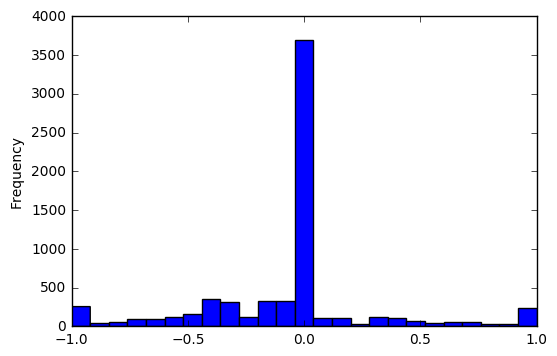

In [18]:
data_df_ns=data_df_ns.assign(one_over_r=lambda x:[one_over_r(steering) for steering in x.steering])
data_df_ns.columns
data_df_ns['steering'].plot.hist(bins=25)

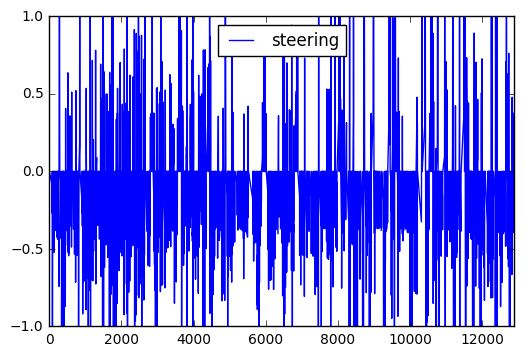

In [19]:
data_df_ns[['steering']].plot()

In [24]:
data_df_ns.describe()

,steering,throttle,brake,speed,one_over_r
count,6990.000000,6990.000000,6990.000000,6990.000000,6990.000000
mean,-0.061765,0.600222,0.052030,22.400958,-0.001715
std,0.371622,0.474731,0.213902,10.048746,0.010315
min,-1.000000,0.000000,0.000000,0.000040,-0.027746
25%,-0.173389,0.000000,0.000000,15.175952,-0.004816
50%,0.000000,1.000000,0.000000,29.651655,0.000000
75%,0.000000,1.000000,0.000000,30.189610,0.000000
max,1.000000,1.000000,1.000000,30.437890,0.027746


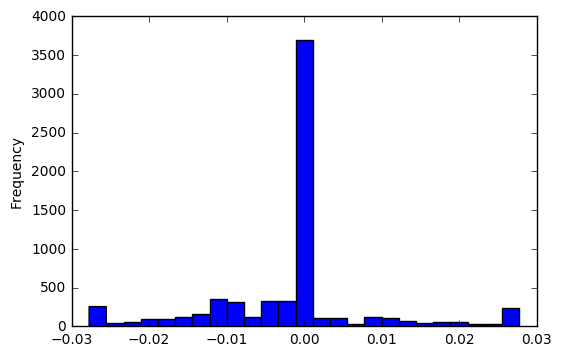

In [21]:
data_df_ns['one_over_r'].plot.hist(bins=25)

In [23]:
len(data_df_ns.loc[data_df_ns['steering'] == 0.0])

3495

In [38]:
from pathlib import PurePosixPath
import cv2
import os
from datetime import datetime
import matplotlib.gridspec as gridspec

In [39]:
def image_files(path,camera='center'):
    return[path+f for f in os.listdir(path) if camera in str(f)]

In [38]:
center_camera_files=image_files(path+'IMG/')
left_camera_files=image_files(path+'IMG/',camera='left')
right_camera_files=image_files(path+'IMG/',camera='right')

In [39]:
print(len(left_camera_files),len(center_camera_files),len(right_camera_files))

24183 24183 24183


In [40]:
print(left_camera_files[0])
print(center_camera_files[0])
print(right_camera_files[0])

p = PurePosixPath(left_camera_files[0])
split=p.stem.split('_')
camera=split.pop(0)
dts=np.asarray(split, dtype=np.int)
print(camera, dts, datetime(dts[0],dts[1],dts[2],dts[3],dts[4],dts[5],dts[6]))

/home/octo/Desktop/simulator-linux/IMG/left_2017_01_28_01_01_58_911.jpg
/home/octo/Desktop/simulator-linux/IMG/center_2017_01_28_00_53_17_030.jpg
/home/octo/Desktop/simulator-linux/IMG/right_2017_01_27_18_16_20_518.jpg
left [2017    1   28    1    1   58  911] 2017-01-28 01:01:58.000911


In [41]:
data_df.iloc[100]

center      /home/octo/Desktop/simulator-linux/IMG/center_...
left         /home/octo/Desktop/simulator-linux/IMG/left_2...
right        /home/octo/Desktop/simulator-linux/IMG/right_...
steering                                                    0
throttle                                             0.694457
brake                                                       0
speed                                                 10.7784
Name: 100, dtype: object

In [56]:
def load_image(path, filename):
    filename = filename.strip()
    if filename.startswith('IMG'):
        filename = path+'/'+filename
    else:
        # load it relative to where log file is now, not whats in it
        filename = path+'/IMG/'+PurePosixPath(filename).name

    img = cv2.imread(filename)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

def randomise_image_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # brightness
    bv = .3 + np.random.random()
    hsv[::2] = hsv[::2]*bv

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def jitter_image_rotation(image, steering):
    rows, cols, _ = image.shape
    transRange = 50
    numPixels = 10
    valPixels = 0.4
    transX = transRange * np.random.uniform() - transRange/2
    steering = steering + transX/transRange * 2 * valPixels
    transY = numPixels * np.random.uniform() - numPixels/2
    transMat = np.float32([[1,0, transX], [0,1, transY]])
    image = cv2.warpAffine(image, transMat, (cols, rows))
    return (image, steering)

def plot_jitter_sample(data_df, idx):
    logdata=data_df.iloc[idx]
    img1 = load_image(path, logdata.center)
    steering1 = logdata.steering
    img2, steering2 = jitter_image_rotation(img1, steering1)
    img2 = randomise_image_brightness(img2)
    fig = plt.figure(dpi=200)
    gs1 = gridspec.GridSpec(1,2,wspace=0.05)
    fig.add_subplot(gs1[0])
    plt.title(steering1)
    plt.axis('off')
    plt.imshow(img1)
    fig.add_subplot(gs1[1])
    plt.title(steering2)
    plt.axis('off')
    plt.imshow(img2)

def draw_cameras(img_left, img_center, img_right, telemetry):
    height = img_center.shape[0]
    width = img_center.shape[1]
    steering = telemetry['steering']
    
    txt='%.3f/%.3f' % (steering,one_over_r(steering))
    
    pad=np.zeros((height,10,3), np.uint8)
    
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.putText(img_center,txt,(int(width/2)-75,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    
    return np.hstack((img_left, pad, img_center, pad, img_right))

def plot_cameras(img_left, img_center, img_right):
    fig = plt.figure(dpi=200)
    gs1 = gridspec.GridSpec(1,3,wspace=0.05)
    fig.add_subplot(gs1[0])
    plt.imshow(img_left)
    plt.title('left')
    plt.axis('off')
    fig.add_subplot(gs1[1])
    plt.imshow(img_center)
    plt.title('center')
    plt.axis('off')
    fig.add_subplot(gs1[2])
    plt.imshow(img_right)
    plt.title('right')
    plt.axis('off')    

def get_telemetry(row):
    vehicle_controls = ['steering', 'throttle', 'brake']
    controls = {control:getattr(row, control) for control in vehicle_controls}
    return controls

def crop_camera(img, crop_height=66, crop_width=200):
    height = img.shape[0]
    width = img.shape[1]
    
#     y_start=60+random.randint(-10,10)
#     x_start=int(width/2)-int(crop_width/2)+random.randint(-40,40)
    y_start=60
    x_start=int(width/2)-int(crop_width/2)
    
    return img[y_start:y_start+crop_height,x_start:x_start+crop_width]
    
def load_and_plot(log_index):
    logdata=data_df.iloc[log_index]
    t=get_telemetry(logdata)
    img_left=load_image(log_path, logdata.left)
    img_center=load_image(log_path, logdata.center)
    img_right=load_image(log_path, logdata.right)
    plot_cameras(img_left, img_center, img_right)

def load_and_draw(data_df,log_path, log_index):
    logdata=data_df.iloc[log_index]
    t=get_telemetry(logdata)
    img_left=crop_camera(load_image(log_path, logdata.left))
    img_center=crop_camera(load_image(log_path, logdata.center))
    img_right=crop_camera(load_image(log_path, logdata.right))
    return draw_cameras(img_left, img_center, img_right,t)    

def create_movie_from_log(log_path,log_file='driving_log.csv',skiprows=1,clip_name='log_clip.mp4', sample_every=1):
    column_names = ['center', 'left', 'right',
                    'steering', 'throttle', 'brake', 'speed']
    data_df = pd.read_csv(log_path+'/'+log_file,
                          names=column_names, skiprows=skiprows)
    
    clip_data=[load_and_draw(data_df, log_path, idx) for idx in data_df.index if not idx % sample_every]
    clip = ImageSequenceClip(clip_data, fps=50)
    %time clip.write_videofile(clip_name, audio=False)
def augment_log_data(data_df,cname='steering'):
    mu = 0
    sigma = 0.2
    
    zero_total = len(data_df.loc[data_df[cname] == 0.0])
    print("zero angle total: ", zero_total)
    
    bin_len=15
    # bins with values from -1 to 1
    bin = np.linspace(-1, 1, bin_len)
    
    # middle bin is 0.0 steering angle
    assert bin[int(bin_len/2)] == 0.0
    
    for b in range(len(bin)):
        # select rows for this bin
        if bin[b] == 0.0:
            bd_count = zero_total
            bd_df = data_df[data_df[cname] == 0.0]
        elif bin[b] < 0.0:
            bd_df = data_df[data_df[cname].between(bin[b],bin[b+1]-0.0001)]
            bd_count=len(bd_df)
        else:
            bd_df = data_df[data_df[cname].between(bin[b-1]+0.0001,bin[b])]
            bd_count=len(bd_df)
        
        # work out count for a gausian distribution
        if b == int(bin_len/2):
            bd_desired=zero_total
        else:
            bd_desired=int((zero_total/2.) * norm.pdf(bin[b], mu, sigma))
     
        print("bin[%.2d] %s: %f count: %d desired: %d" % (b,cname,bin[b],bd_count,bd_desired))
        
        # append extra rows
        bd_needed = bd_desired - bd_count
        if bd_needed > 0 and bd_count > 0:
            bd_df=bd_df.sample(frac=(1.*bd_desired/bd_count), replace=True)
        
        # first time through save the dataframe for later bins to append to
        if b == 0:
            final_df = bd_df
            
        else:
            final_df = final_df.append(bd_df, ignore_index=True)
    
    return final_df       

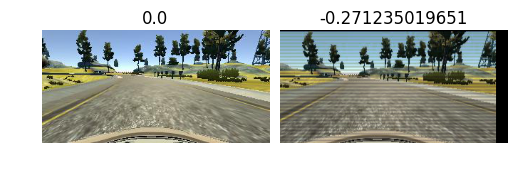

In [47]:
plot_jitter_sample(data_df,4250)

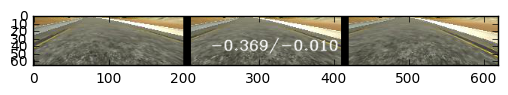

In [49]:
import random
plt.imshow(load_and_draw(data_df_ns,path,log_index=4300))

In [50]:
from moviepy.editor import *
from IPython.display import HTML

In [54]:
clip_name='udacity_sample.mp4'
create_movie_from_log(path,skiprows=1,clip_name=clip_name,sample_every=1)

[MoviePy] >>>> Building video udacity_sample.mp4
[MoviePy] Writing video udacity_sample.mp4


100%|██████████| 24182/24182 [01:27<00:00, 275.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: udacity_sample.mp4 

CPU times: user 1min 22s, sys: 2.19 s, total: 1min 24s
Wall time: 1min 28s


In [55]:
HTML("""
<video width="960" height="150" controls>
  <source src="{0}">
</video>
""".format(clip_name))

zero angle total:  3495
bin[00] steering: -1.000000 count: 287 desired: 0
bin[01] steering: -0.857143 count: 108 desired: 0
bin[02] steering: -0.714286 count: 181 desired: 5
bin[03] steering: -0.571429 count: 292 desired: 58
bin[04] steering: -0.428571 count: 626 desired: 350
bin[05] steering: -0.285714 count: 441 desired: 1256
bin[06] steering: -0.142857 count: 498 desired: 2700
bin[07] steering: 0.000000 count: 3495 desired: 3495
bin[08] steering: 0.142857 count: 168 desired: 2700
bin[09] steering: 0.285714 count: 138 desired: 1256
bin[10] steering: 0.428571 count: 212 desired: 350
bin[11] steering: 0.571429 count: 127 desired: 58
bin[12] steering: 0.714286 count: 89 desired: 5
bin[13] steering: 0.857143 count: 62 desired: 0
bin[14] steering: 1.000000 count: 262 desired: 0


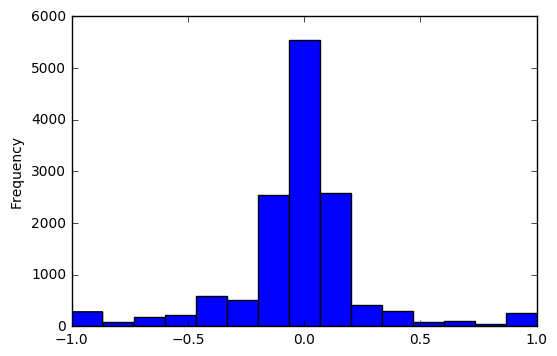

In [57]:
a_df=augment_log_data(data_df_ns)
a_df['steering'].plot.hist(bins=15)   